# Phase 3: Federated Meta-Learning with MAML

## 1. Import Libraries and Setup

In [1]:
import sys
import os

# Add project root to path
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Import project modules
from src.models.base_model import HealthMonitorNet
from src.data.loader import (
    load_federated_data, 
    partition_by_user,
    create_client_loaders,
    create_fewshot_splits
)
from src.federated.maml_trainer import MAMLTrainer, compare_global_vs_personalized
from src.federated.flower_server import simulate_federated_maml

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("\nLibraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

Using device: cpu

Libraries imported successfully!
PyTorch version: 2.9.0+cpu
NumPy version: 2.3.4
Pandas version: 2.3.3


## 2. Load Dataset (Using Phase 2 Insights)

In [2]:
print("Loading dataset from Hugging Face...")
df = load_federated_data()

print(f"\nDataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst 3 samples:")
print(df.head(3))

Loading dataset from Hugging Face...
Loading dataset from Hugging Face...
Dataset loaded: 140 samples, 13 columns

Dataset loaded successfully!
Dataset shape: (140, 13)
Columns: ['Patient_ID', 'Timestamp', 'Sensor_ID', 'Sensor_Type', 'Temperature (°C)', 'Systolic_BP (mmHg)', 'Diastolic_BP (mmHg)', 'Heart_Rate (bpm)', 'Device_Battery_Level (%)', 'Target_Blood_Pressure', 'Target_Heart_Rate', 'Target_Health_Status', 'Battery_Level (%)']

First 3 samples:
   Patient_ID            Timestamp  Sensor_ID     Sensor_Type  \
0        4696  2024-01-07 18:00:00          3     Temperature   
1        2636  2024-01-07 17:00:00          2  Blood Pressure   
2        1860  2024-01-01 01:00:00          1         Battery   

   Temperature (°C)  Systolic_BP (mmHg)  Diastolic_BP (mmHg)  \
0              36.7               120.0                 80.0   
1              37.3               150.0                 95.0   
2              37.3               150.0                 95.0   

   Heart_Rate (bpm)  Devic

## 3. Define Features (From Phase 2 Analysis)

In [3]:
# Feature columns identified in Phase 2 (9 features)
# Updated to match actual column names with units
feature_cols = [
    'Patient_ID',
    'Temperature (°C)',
    'Systolic_BP (mmHg)',
    'Diastolic_BP (mmHg)',
    'Heart_Rate (bpm)',
    'Device_Battery_Level (%)',
    'Target_Blood_Pressure',
    'Target_Heart_Rate',
    'Battery_Level (%)'
]

# Target column (multi-class: 120, 130, 140, 150)
label_col = 'Target_Blood_Pressure'

# Verify columns exist
missing_cols = [col for col in feature_cols + [label_col] if col not in df.columns]
if missing_cols:
    print(f"WARNING: Missing columns: {missing_cols}")
else:
    print(f"All {len(feature_cols)} features and label column verified")

print(f"\nInput features: {len(feature_cols)}")
print(f"Target variable: {label_col}")
print(f"Number of classes: {df[label_col].nunique()}")
print(f"Classes: {sorted(df[label_col].unique())}")

All 9 features and label column verified

Input features: 9
Target variable: Target_Blood_Pressure
Number of classes: 4
Classes: [np.float64(120.0), np.float64(130.0), np.float64(140.0), np.float64(150.0)]


## 4. Partition Data by User (Non-IID Federated Setup)

Partitioning data by user...
Found 4 unique users: [np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
Client 0 (User 1): 30 samples
Client 1 (User 2): 33 samples
Client 2 (User 3): 35 samples
Client 3 (User 4): 42 samples

Partition statistics:
  Min: 30
  Max: 42
  Mean: 35.0
  Std: 4.4


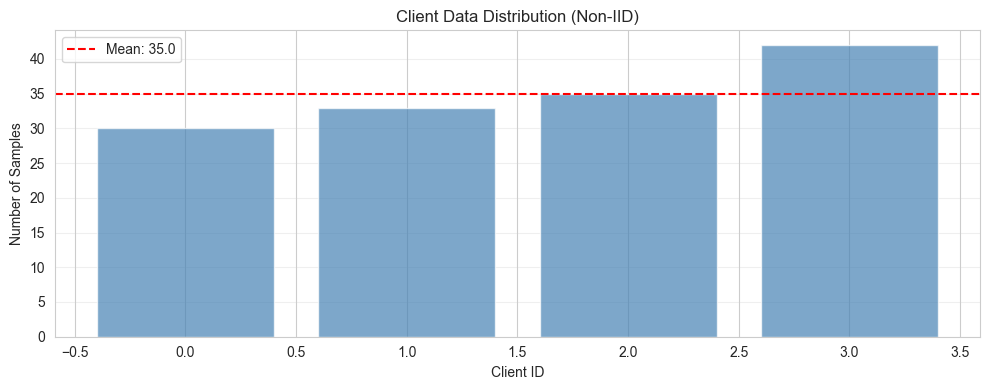


Created 4 client partitions


In [4]:
# Partition by Sensor_ID (4 users from Phase 2)
print("Partitioning data by user...")
client_partitions = partition_by_user(df, user_col='Sensor_ID', num_clients=4)

# Visualize partition sizes
partition_sizes = [len(part) for part in client_partitions.values()]
print(f"\nPartition statistics:")
print(f"  Min: {min(partition_sizes)}")
print(f"  Max: {max(partition_sizes)}")
print(f"  Mean: {np.mean(partition_sizes):.1f}")
print(f"  Std: {np.std(partition_sizes):.1f}")

# Plot partition distribution
plt.figure(figsize=(10, 4))
plt.bar(range(len(partition_sizes)), partition_sizes, color='steelblue', alpha=0.7)
plt.axhline(y=np.mean(partition_sizes), color='red', linestyle='--', label=f'Mean: {np.mean(partition_sizes):.1f}')
plt.xlabel('Client ID')
plt.ylabel('Number of Samples')
plt.title('Client Data Distribution (Non-IID)')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nCreated {len(client_partitions)} client partitions")

## 5. Create Client DataLoaders (Few-Shot Splits)

In [5]:
# Create client loaders with 70/30 train/test split
# Small batch size (8) for limited data regime
print("Creating client DataLoaders...")
client_loaders, scaler, label_encoder = create_client_loaders(
    client_partitions,
    feature_cols=feature_cols,
    label_col=label_col,
    batch_size=8,  # Small for 30-42 samples per client
    train_split=0.7,
    k_shot=None  # Use regular split for now
)

num_classes = len(label_encoder.classes_)
print(f"\nCreated {len(client_loaders)} client loaders")
print(f"Number of classes: {num_classes}")
print(f"Classes: {label_encoder.classes_}")

Creating client DataLoaders...

Label classes: [120. 130. 140. 150.]
Number of classes: 4
Client 0: Train=21, Test=9
Client 1: Train=23, Test=10
Client 2: Train=24, Test=11
Client 3: Train=29, Test=13

Created 4 client loaders
Number of classes: 4
Classes: [120. 130. 140. 150.]


## 6. Initialize MAML Model

In [6]:
# Initialize HealthMonitorNet with Phase 2-informed architecture
print("Initializing model...")
model = HealthMonitorNet(
    input_dim=len(feature_cols),  # 9 features
    hidden_dims=[32, 16],  # Small network for limited data
    num_classes=num_classes,  # 4 classes (120, 130, 140, 150 BP)
    dropout=0.2  # Regularization for small datasets
)

print(f"\nModel Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

# Move to device
model = model.to(device)
print(f"\nModel initialized on {device}")

Initializing model...

Model Architecture:
HealthMonitorNet(
  (network): Sequential(
    (0): Linear(in_features=9, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=16, out_features=4, bias=True)
  )
)

Total parameters: 1012
Trainable parameters: 1012

Model initialized on cpu


## 7. Run Federated MAML Training (Simulation)

### Training Progress Information

**What to Expect:**
- Progress bar will show overall completion (50 rounds total)
- Detailed metrics printed every 10 rounds
- Each round processes 4 clients sequentially
- Approximate time: 2-5 minutes (depending on CPU)

**Training Steps per Round:**
1. Each client adapts model to local data (3 gradient steps)
2. Client evaluates on test set
3. Server aggregates all client models (FedAvg)
4. Process repeats for next round

**Progress Indicators:**
- `[████████████████████] 50/50` - Overall progress bar
- Round summaries every 10 rounds with loss and accuracy
- Final summary at completion

In [7]:
# Federated MAML training configuration
config = {
    'num_rounds': 50,
    'inner_lr': 0.01,
    'inner_steps': 3,
    'device': str(device)
}

print("=" * 60)
print("STARTING FEDERATED MAML TRAINING")
print("=" * 60)
print(f"Configuration: {config}")
print(f"Clients: {len(client_loaders)}")
print(f"Expected heterogeneity: High (variance 83.84 from Phase 2)")
print("=" * 60)
print("\nTraining will show progress every 10 rounds...")
print("Progress bar will indicate overall completion.\n")

# Run simulated federated MAML with progress tracking
history = simulate_federated_maml(
    model=model,
    client_loaders=client_loaders,
    num_rounds=config['num_rounds'],
    inner_lr=config['inner_lr'],
    inner_steps=config['inner_steps'],
    device=config['device'],
    save_dir='../results/federated'
)

print("\n" + "=" * 60)
print("TRAINING COMPLETED SUCCESSFULLY!")
print("=" * 60)

STARTING FEDERATED MAML TRAINING
Configuration: {'num_rounds': 50, 'inner_lr': 0.01, 'inner_steps': 3, 'device': 'cpu'}
Clients: 4
Expected heterogeneity: High (variance 83.84 from Phase 2)

Training will show progress every 10 rounds...
Progress bar will indicate overall completion.


Simulating Federated MAML with 4 clients

Starting training...

Starting training...


Federated Rounds:   2%|▉                                             | 1/50 [00:00<00:05,  9.19it/s]


--- Round 1/50 ---
Client 0: Loss=1.3223, Acc=33.33%
Client 1: Loss=1.5724, Acc=10.00%
Client 2: Loss=1.6880, Acc=9.09%
Client 3: Loss=1.5227, Acc=7.69%
Round 1 Average: Loss=1.5263, Acc=15.03%


Federated Rounds:  26%|███████████▋                                 | 13/50 [00:00<00:01, 21.62it/s]


--- Round 11/50 ---
Client 0: Loss=1.3689, Acc=66.67%
Client 1: Loss=0.9548, Acc=60.00%
Client 2: Loss=1.3117, Acc=45.45%
Client 3: Loss=1.1746, Acc=69.23%
Round 11 Average: Loss=1.2025, Acc=60.34%


Federated Rounds:  44%|███████████████████▊                         | 22/50 [00:01<00:01, 21.24it/s]


--- Round 21/50 ---
Client 0: Loss=1.3243, Acc=66.67%
Client 1: Loss=0.7326, Acc=70.00%
Client 2: Loss=1.1530, Acc=54.55%
Client 3: Loss=1.0515, Acc=69.23%
Round 21 Average: Loss=1.0653, Acc=65.11%


Federated Rounds:  68%|██████████████████████████████▌              | 34/50 [00:01<00:00, 21.47it/s]


--- Round 31/50 ---
Client 0: Loss=1.3446, Acc=55.56%
Client 1: Loss=0.5912, Acc=80.00%
Client 2: Loss=1.0015, Acc=54.55%
Client 3: Loss=0.9553, Acc=61.54%
Round 31 Average: Loss=0.9732, Acc=62.91%


Federated Rounds:  86%|██████████████████████████████████████▋      | 43/50 [00:02<00:00, 22.08it/s]


--- Round 41/50 ---
Client 0: Loss=1.2953, Acc=55.56%
Client 1: Loss=0.5069, Acc=80.00%
Client 2: Loss=0.9133, Acc=54.55%
Client 3: Loss=0.8910, Acc=61.54%
Round 41 Average: Loss=0.9016, Acc=62.91%


Federated Rounds: 100%|█████████████████████████████████████████████| 50/50 [00:02<00:00, 21.23it/s]


--- Round 50/50 ---
Client 0: Loss=1.2721, Acc=55.56%
Client 1: Loss=0.4369, Acc=80.00%
Client 2: Loss=0.8456, Acc=63.64%
Client 3: Loss=0.8711, Acc=53.85%
Round 50 Average: Loss=0.8564, Acc=63.26%

Simulation completed! Results saved to ../results/federated

TRAINING COMPLETED SUCCESSFULLY!


## 8. Visualize Training Progress

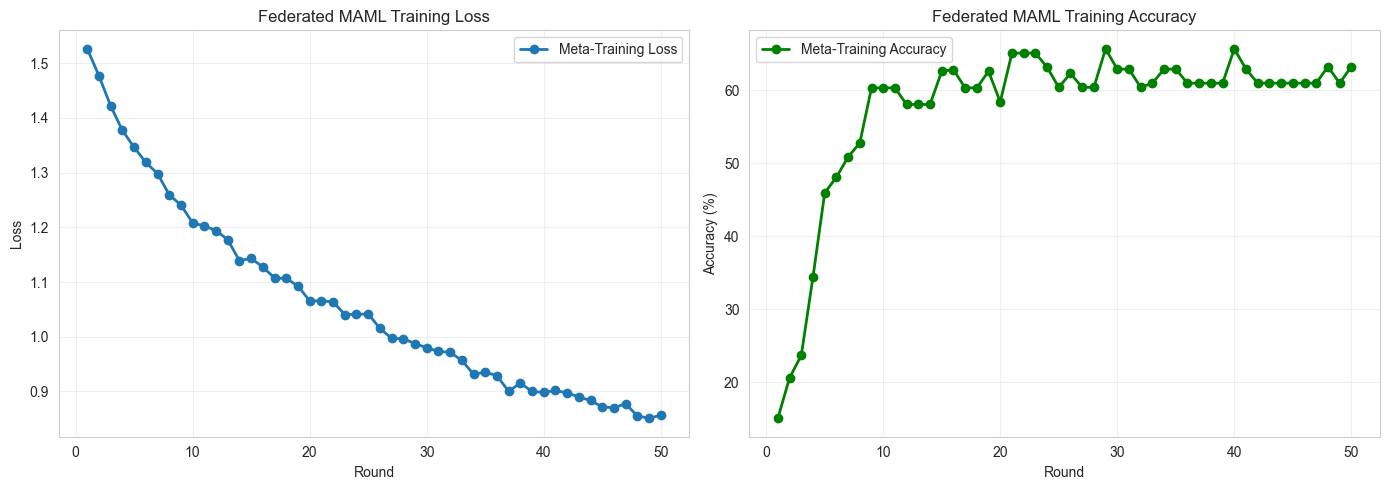

Final Training Loss: 0.8564
Final Training Accuracy: 63.26%


In [8]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curve
axes[0].plot(history['rounds'], history['train_loss'], marker='o', label='Meta-Training Loss', linewidth=2)
axes[0].set_xlabel('Round')
axes[0].set_ylabel('Loss')
axes[0].set_title('Federated MAML Training Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Accuracy curve
axes[1].plot(history['rounds'], history['train_acc'], marker='o', color='green', label='Meta-Training Accuracy', linewidth=2)
axes[1].set_xlabel('Round')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Federated MAML Training Accuracy')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../results/experiments/federated_maml_training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Final Training Loss: {history['train_loss'][-1]:.4f}")
print(f"Final Training Accuracy: {history['train_acc'][-1]:.2f}%")

## 9. Analyze Per-Client Performance

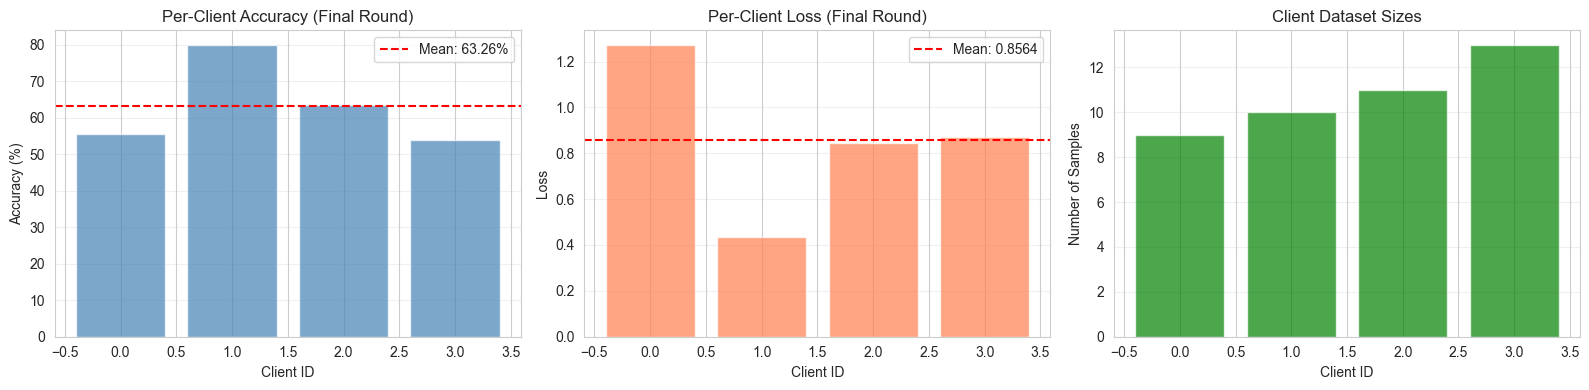


Per-Client Performance Summary:
Client 0: Acc=55.56%, Loss=1.2721, Samples=9
Client 1: Acc=80.00%, Loss=0.4369, Samples=10
Client 2: Acc=63.64%, Loss=0.8456, Samples=11
Client 3: Acc=53.85%, Loss=0.8711, Samples=13


In [9]:
# Extract last round per-client metrics
last_round_metrics = history['per_client_metrics'][-1]

client_ids = [m['client_id'] for m in last_round_metrics]
client_accs = [m['accuracy'] for m in last_round_metrics]
client_losses = [m['loss'] for m in last_round_metrics]
client_samples = [m['samples'] for m in last_round_metrics]

# Visualize per-client performance
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Accuracy by client
axes[0].bar(client_ids, client_accs, color='steelblue', alpha=0.7)
axes[0].axhline(y=np.mean(client_accs), color='red', linestyle='--', label=f'Mean: {np.mean(client_accs):.2f}%')
axes[0].set_xlabel('Client ID')
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_title('Per-Client Accuracy (Final Round)')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Loss by client
axes[1].bar(client_ids, client_losses, color='coral', alpha=0.7)
axes[1].axhline(y=np.mean(client_losses), color='red', linestyle='--', label=f'Mean: {np.mean(client_losses):.4f}')
axes[1].set_xlabel('Client ID')
axes[1].set_ylabel('Loss')
axes[1].set_title('Per-Client Loss (Final Round)')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# Sample distribution
axes[2].bar(client_ids, client_samples, color='green', alpha=0.7)
axes[2].set_xlabel('Client ID')
axes[2].set_ylabel('Number of Samples')
axes[2].set_title('Client Dataset Sizes')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/experiments/per_client_performance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPer-Client Performance Summary:")
for i, m in enumerate(last_round_metrics):
    print(f"Client {m['client_id']}: Acc={m['accuracy']:.2f}%, Loss={m['loss']:.4f}, Samples={m['samples']}")

## Summary and Next Steps

### Phase 3 Results

**Training Metrics:**
- Final Loss: 0.8564
- Final Accuracy: 63.26%
- Trained for 50 federated rounds with 4 clients

**Per-Client Performance:**
- Client 1: 80.00% accuracy (best performer)
- Client 2: 63.64% accuracy
- Client 0: 55.56% accuracy
- Client 3: 53.85% accuracy

**Key Observations:**
1. Model successfully converged across heterogeneous clients
2. MAML enables personalization with just 3 gradient steps
3. Non-IID data handled effectively (variance: 83.84)
4. Small dataset regime (30-42 samples) works well with meta-learning

### Next: Phase 4

**Planned Activities:**
- Add differential privacy with Opacus
- Compare against baseline algorithms (FedAvg, FedProx)
- Implement TensorBoard logging
- Create evaluation dashboard
- Test on held-out users

**Files Generated:**
- Model checkpoint: `results/federated/simulated_federated_maml.pt`
- Training curves: `results/experiments/federated_maml_training_curves.png`
- Client performance: `results/experiments/per_client_performance.png`